# Low Light Response Analysis

This notebook provides the steps to analyze the waveform produced by real data from a single SiPM low light response. Multiple estimation procedures are implemented to speed up the extraction of the relevant parameters:

[__1.__](#Gaussian-Parameter-Estimation) Gaussian peaks are fit to the raw data to extract estimates for 6 of the 9 total variables. 

[__2.__](#Simplified-Fitting-Routine) A simplified fitting routine is run using the results of the gaussian estimation in order to find estimates for the remaining 3 variables. The 6 parameters with an estimate from the gaussian are fixed, and the 3 without an estimate area allowed to float. The results provide estimates for the other 3 variables.

[__3.__](#Final-Fit) The final fit is run where all 9 variables are allowed to float, and each of their estimates based on the previous two steps are passed to the fitting routine to help direct it where to expect the final correct values. The upper and lower bounds for the variables are also set based on their estimated value and what is logically reasonable, erring toward a smaller area to help speed up processing. A program is implemented to rerun the fit if the bounds selected are too limiting to avoid returning innacurate fits

We first start by importing all the packages we will need

In [1]:
import sipmanalyze
import sipmpdf

import zfit
import numpy as np
import sipmanalyze.plotting as plot
import datetime

2024-02-05 22:39:49.863566: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-05 22:39:49.865033: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-05 22:39:49.892688: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-05 22:39:49.893186: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-05 22:39:50.378979: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

# Importing Data

The fitting routines assumes the input in the 1 dimensional histogram, given in
the `hist.Hist` format. Methods for how to do this given the various data sets
can be found in the `formats.histogram_output` module.

<Axes: xlabel='Readout [mV-ns]'>

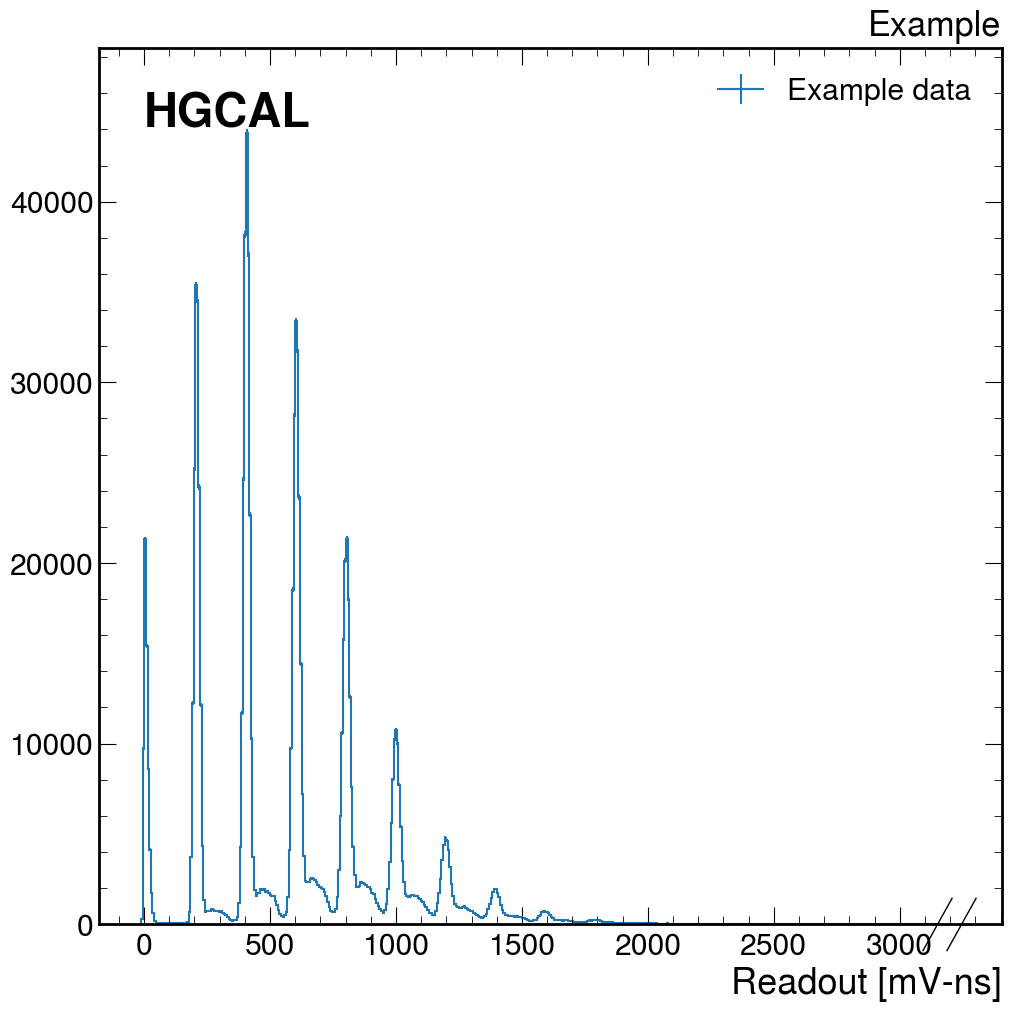

In [2]:
data_hist = sipmanalyze.formats.histogram_output.from_waveform(
    "data/picoblock_20190430_lasertrigger.root", start=5, stop=45
)

# plot the data
fig, ax = plot.make_simple_figure()
plot.plot_data1d(ax=ax, data=data_hist, label="Example data")
ax.legend()
plot.add_std_label(ax=ax, label="", rlabel="Example")

# Gaussian Parameter Estimation

In this step we fit gaussian curves to each of the peaks in the raw data in
order to extract estimates for 6 parameters: pedestal, gain, common noise, pixel
noise, poisson mean, poisson borel.

## Gaussian Parameter Estimation: Find Peaks in the Data

We start by finding the locations of each of the peaks in the data. The code for
this step uses the function __[`scipy.signal.find_peak`][find_peak]__. The
provided function will return a numpy array of estimate peak positions. 

Additional methods can be provided to modify the peak finding behavior

- _min_gain_guess_: the minimum gain expected in the data
- _min_ratio_guess_: the minimum height allowed for a peak as a fraction of the tallest peak

[find_peak]: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html

<Axes: xlabel='Readout [mV-ns]'>

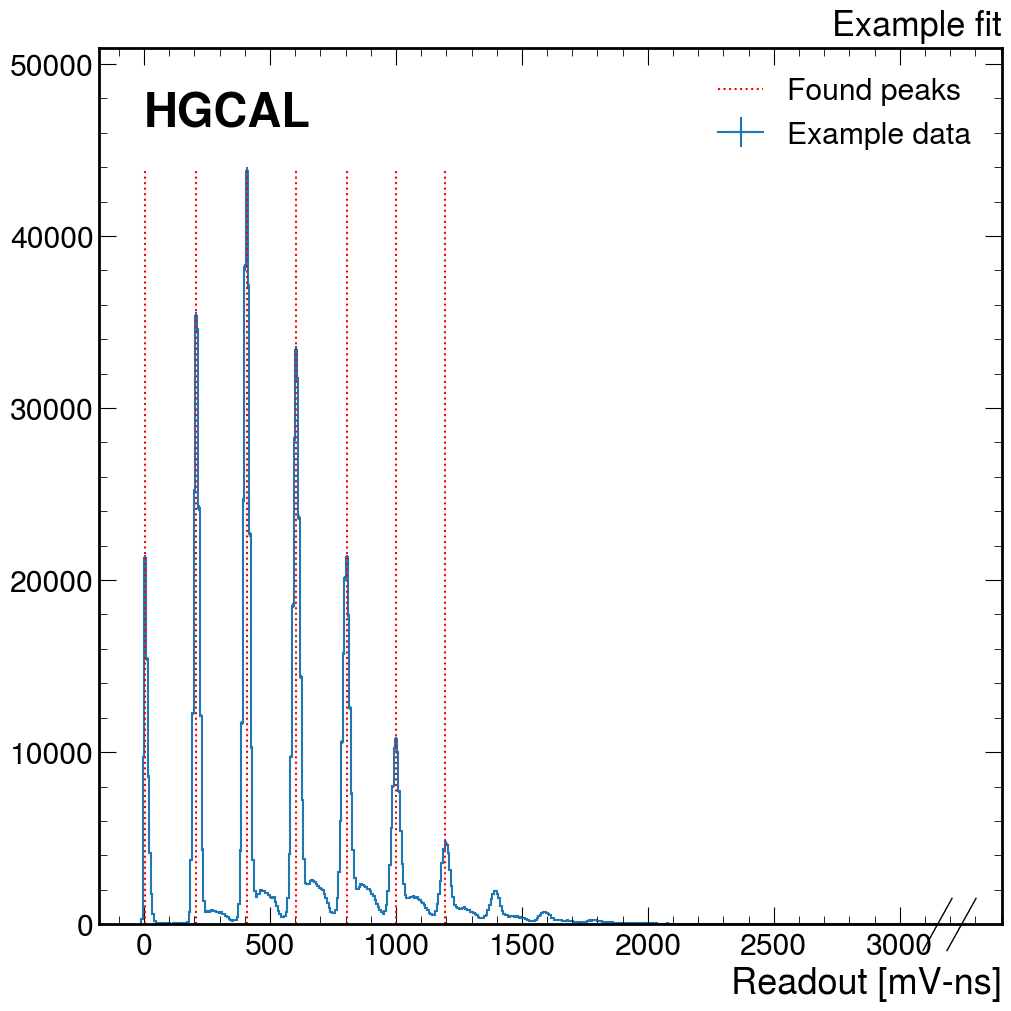

In [3]:
start_of_estimation_routine = datetime.datetime.now()

### Adjustable Optional Parameters for get_peaks ###
min_gain_guess = 80
min_ratio_guess = 1 / 20.0
#############################

# get the peak_results
peak_results = sipmanalyze.estimate.lowlight.estimate_peaks(data_hist)

# plot the peaks
fig,ax = plot.make_simple_figure()
plot.plot_data1d(ax=ax, data=data_hist, label='Example data')
ax.vlines(peak_results, 0, np.max(data_hist.view()), color='red', ls='dotted', label='Found peaks')
ax.legend()
plot.add_std_label(ax=ax, rlabel='Example fit')

## Gaussian Paramter Estimation: Fit Gaussian Curves

After extracting the Guassian fits, we will extract perform a local Guassian fit
to extract the estimated normalization. The underlying methods runs a simple
`scipy.optimize.curve_fit` method to the found peaks. The estimation function
returns a dictionary of the various Gaussian parameters for which the simple fit
converges.

An addtional variable that the user may provide to the estimation functions is
the `fit_bin_count`, which determins now many neighboring bins to take into
account for each of the local fits.

<Axes: xlabel='Readout [mV-ns]'>

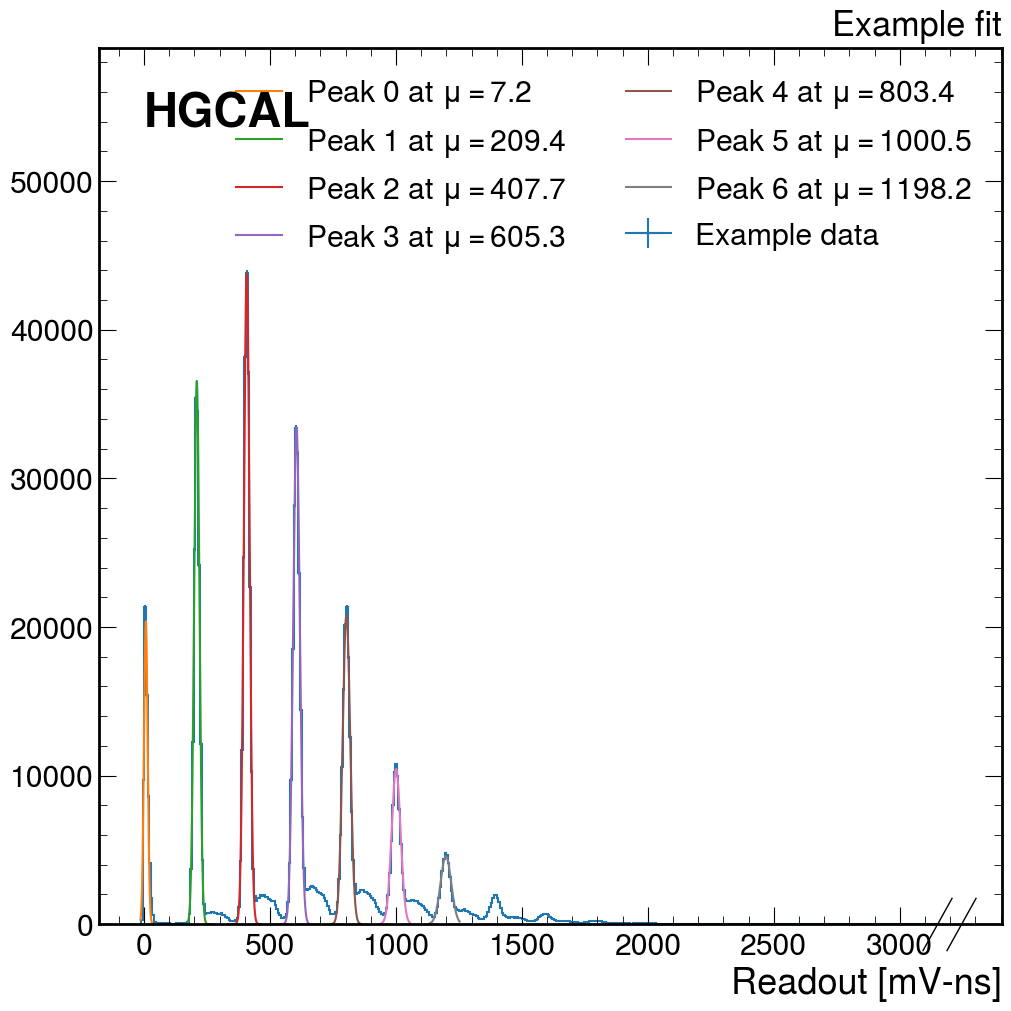

In [4]:
### Adjustable Optional Parameters for gauss_estimate ###
fit_bin_count = 10
#############################

# get the results of gaussian fits
gauss_est = sipmanalyze.estimate.lowlight.estimate_gauss_param(
    data_hist, peak_results, fit_bin_count=fit_bin_count
)

# plot the results
fig, ax = plot.make_simple_figure()
plot.plot_data1d(ax=ax, data=data_hist, label="Example data")

for idx in range(len(gauss_est["peak_id"])):
    peak_idx = gauss_est["peak_id"][idx]
    mu = gauss_est["mu"][idx]
    sig = gauss_est["sigma"][idx]
    norm = gauss_est["norm"][idx]
    xmin, xmax = gauss_est["xrange"][idx]

    x = np.linspace(xmin, xmax, 1000)
    y = norm * sipmpdf.functions.normal(x, mu, sig)
    label = "Peak {idx} at $\mu=${mu:.1f}".format(idx=peak_idx, mu=mu)
    ax.plot(x, y, label=label)
ax.legend(ncol=2)


plot.add_std_label(ax=ax, rlabel="Example fit")

## Gaussian Parameter Estimation: Find the Estimates

From the individual Gaussian fits in the previous results, we will attemp to
extract the Generalized Poission paramaeters, the pedestal+gain based on the
fitted position of the Gaussian fits, as well as the Guassian Noise parameters
that goes into the full model fit. Again. These estimation routines can be
determined by running the curve_fit on the various model parameters.

The return for each of the parameters will be returnd as a dictionary of floats
we we will continuously update.


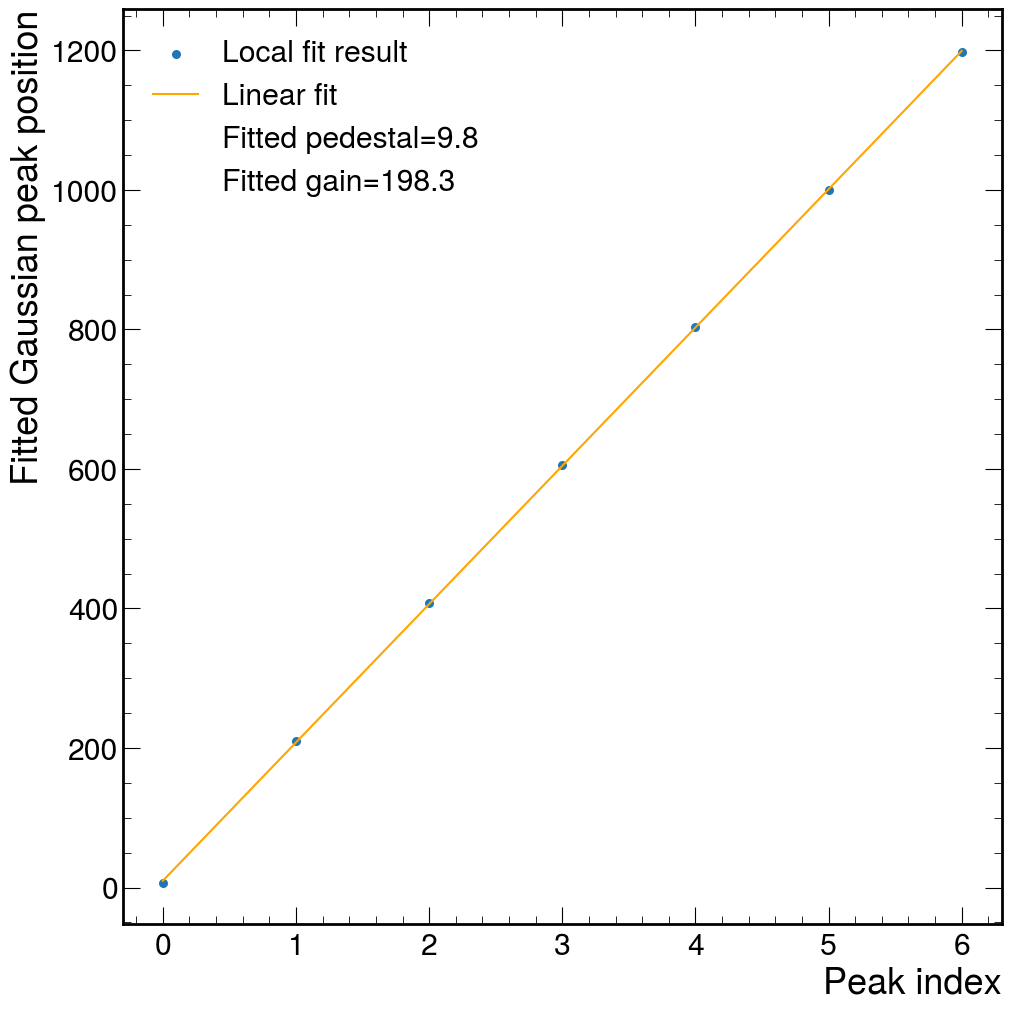

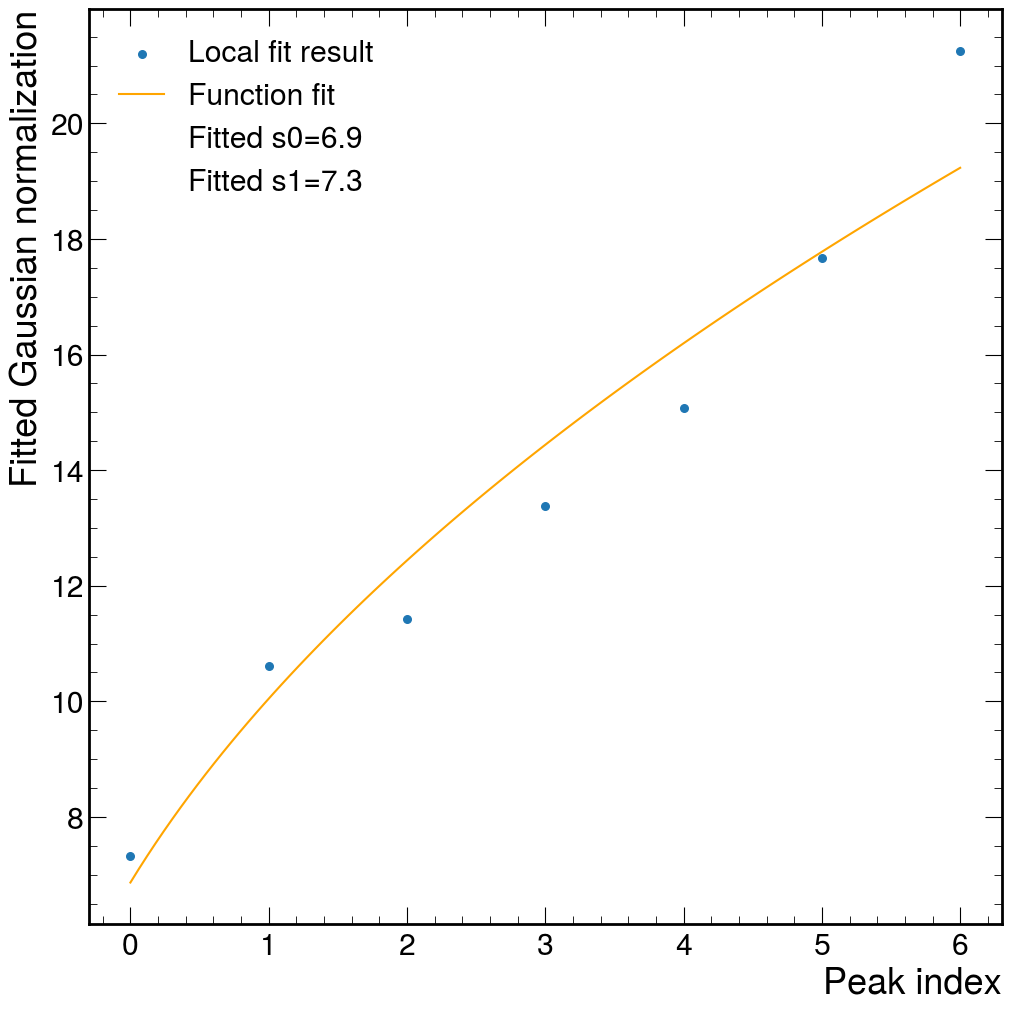

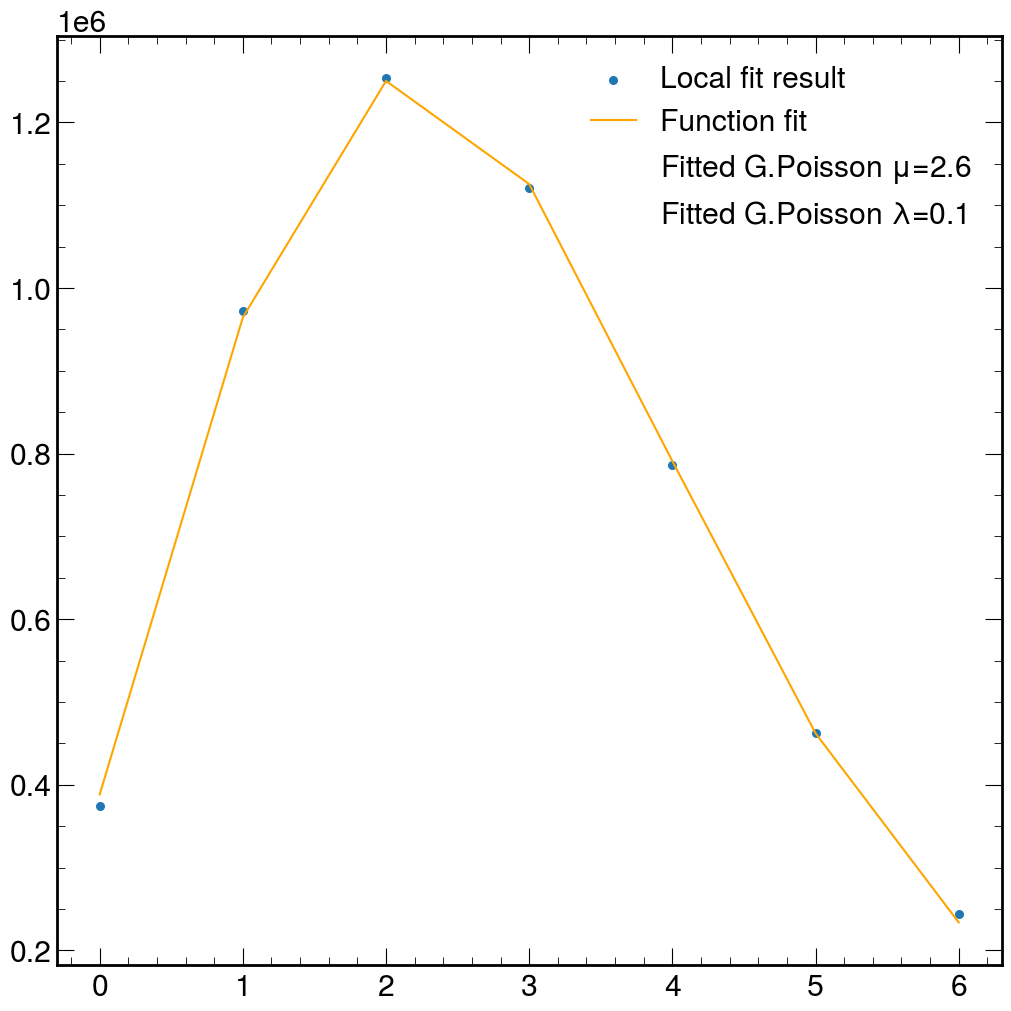

In [5]:
# dictionary for parameter estimates
variable_estimates = {}

# Running the pedestal/gain estimator
variable_estimates.update(
    sipmanalyze.estimate.lowlight.estimate_pedestal_gain(gauss_est)
)
_, ax1 = plot.make_simple_figure()
ax1.scatter(gauss_est["peak_id"], gauss_est["mu"], s=30, label="Local fit result")
x = np.linspace(gauss_est["peak_id"][0], gauss_est["peak_id"][-1], 100)
ax1.plot(
    x,
    variable_estimates["pedestal"] + x * variable_estimates["gain"],
    color="orange",
    label="Linear fit",
)
ax1.plot(
    [],
    [],
    ls="none",
    label="Fitted pedestal={0:.1f}".format(variable_estimates["pedestal"]),
)
ax1.plot(
    [], [], ls="none", label="Fitted gain={0:.1f}".format(variable_estimates["gain"])
)
ax1.set_xlabel("Peak index")
ax1.set_ylabel("Fitted Gaussian peak position")
ax1.legend()

# Running Guassian with estimate
variable_estimates.update(sipmanalyze.estimate.lowlight.estimate_noise_param(gauss_est))
_, ax2 = plot.make_simple_figure()
ax2.scatter(gauss_est["peak_id"], gauss_est["sigma"], s=30, label="Local fit result")
x = np.linspace(gauss_est["peak_id"][0], gauss_est["peak_id"][-1], 100)
s0 = variable_estimates["common_noise"]
s1 = variable_estimates["pixel_noise"]
ax2.plot(
    x,
    np.sqrt(s0 * s0 + x * s1 * s1),
    color="orange",
    label="Function fit",
)
ax2.plot([], [], ls="none", label="Fitted s0={0:.1f}".format(s0))
ax2.plot([], [], ls="none", label="Fitted s1={0:.1f}".format(s1))
ax2.set_xlabel("Peak index")
ax2.set_ylabel("Fitted Gaussian peak width")
ax2.legend()

# Running the Poission estimate
variable_estimates.update(sipmanalyze.estimate.lowlight.estimate_poisson(gauss_est))
_, ax3 = plot.make_simple_figure()
ax3.scatter(gauss_est["peak_id"], gauss_est["norm"], s=30, label="Local fit result")
mu = variable_estimates["poisson_mean"]
lam = variable_estimates["poisson_borel"]
ax3.plot(
    gauss_est["peak_id"],
    variable_estimates["poisson_total"]
    * sipmpdf.functions.generalized_poisson(np.array(gauss_est["peak_id"]), mu, lam),
    label="Function fit",
    color="orange",
)
ax3.plot([], [], ls="none", label="Fitted G.Poisson $\mu$={0:.1f}".format(mu))
ax3.plot([], [], ls="none", label="Fitted G.Poisson $\lambda$={0:.1f}".format(lam))
ax2.set_xlabel("Peak index")
ax2.set_ylabel("Fitted Gaussian normalization")
ax3.legend()

# variable_estimates["poisson_mean"], variable_estimates["poisson_borel"] = (
#    est.poisson_mean_borel_est(gauss_dict)
# )

# Giving an example plot of what is going on

# end_of_estimation_routine = datetime.datetime.now()

# Simplified Fitting Routine

The full implementation for the response function fit is implemented in the
`sipmanalyze.fit.create_response_pdf` method. With a slightly simplified
interface compared with the full `zfit` plot, as the function will automatically
generate the PDF/data object and the corresponding variables given a set of
parameters, which can then be used to call the fitting routine. The `parameter`
dictionary that is passed to the object creation may be used in tandum with the
estimation results: the variable name used for the PDF is the dictionary key,
while the values can either be a singular value (for a fixed value), or multiple
values to indicate the variable range.

For a typical fit we will run the fit routine twice, the first time with the
estimations fixed to speed up the fitting routine.

/home/ensc/.conda/envs/sipm-analyze/lib/python3.10/site-packages/zfit/minimizers/fitresult.py:1204: ChangedFeatureWarning: The behavior of this functionality recently changed.To turn this warning off, use `zfit.settings.changed_warnings.hesse_name = False`  or 'all' with `zfit.settings.changed_warnings.all = False
Default name of hesse (which is currently the method name such as `minuit_hesse`or `hesse_np`) has changed to `hesse` (it still adds the old one as well. This will be removed in the future). INSTRUCTIONS: to stay compatible,  change wherever you access the error to 'hesse' (if you don't explicitly specify the name in hesse(...).
  warn_changed_feature(message, "hesse_name")


FitResult of
<BinnedNLL model=[<zfit.models.tobinned.BinnedFromUnbinnedPDF object at 0x72afa7d7dbd0>] data=[<zfit._data.binneddatav1.BinnedData object at 0x72afa7d7e200>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | internal) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════════╡
│  False  │    True     │       True       │ 0.00037 │             25732.53 |  25708.98 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════════╛

Parameters
name                   value  (rounded)        hesse    at limit
-------------------  ------------------  -----------  ----------
ap_probfix_estimate           0.0970875  +/- 0.00027       False
ap_betafix_estimate             91.3817  +/-    0.51       False
dc_probfix_estimate                0.05  +/- 2.2e-06      

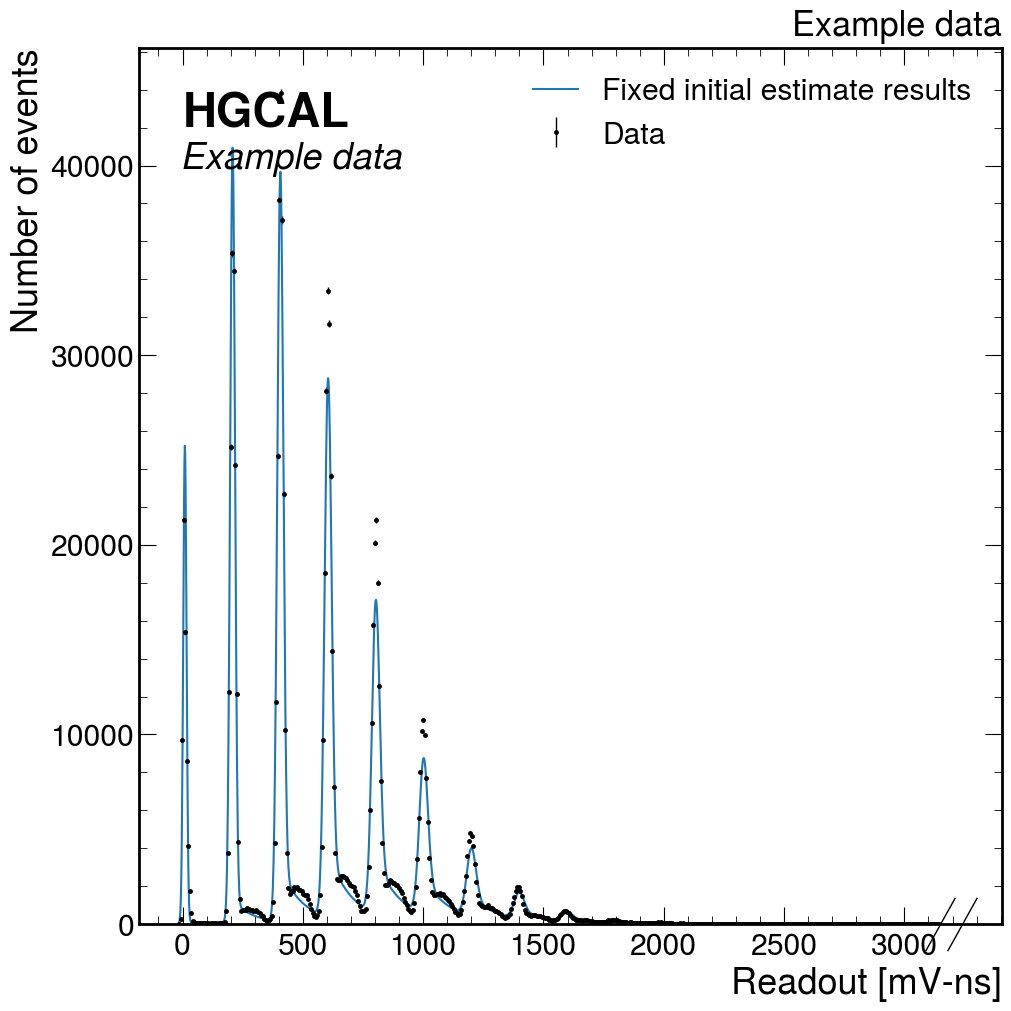

In [6]:
# Creating the zfit objects
gain_fix = variable_estimates["gain"]
parameter_dict = {
    **variable_estimates,
    "ap_beta": (gain_fix, gain_fix * 0.6),
    "ap_prob": (0.05, 0.00001, 0.10),
    "dc_prob": (0.01, 0.00001, 0.05),
    "dc_res": 5e-3,
}
pdf_unbinned, pdf_binned, zfit_data = sipmanalyze.fit.create_response_pdf_data(
    data_hist, parameter_dict, routine_name="fix_estimate"
)


# Running the fitting routine
nll_bin = zfit.loss.BinnedNLL(pdf_binned, zfit_data)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll_bin)
result.hesse()
print(result)


# Plotting the results
fig, ax = plot.make_simple_figure()
plot.plot_data1d(
    ax=ax, data=data_hist, label="Data", histtype="errorbar", color="k", markersize=5
)
plot.plot_pdf1d(
    ax=ax, pdf=pdf_unbinned, data=zfit_data, label="Fixed initial estimate results"
)
plot.add_std_label(ax=ax, label="Example data", rlabel="Example data")
# ax.set_xlabel("Readout [mV-ns]")
ax.set_ylabel("Number of events")
ax.legend()

The second fitting routine we will leave all parameters floating based on the
existing fit. A simplified method can be done by the
`fit.update_response_parameter_bounds` methods, which takes the base parameter
dictionary and the the fitting results. Alternatively, you can also adjust the
relative scale of the desired range.

FitResult of
<BinnedNLL model=[<zfit.models.tobinned.BinnedFromUnbinnedPDF object at 0x72af9c876110>] data=[<zfit._data.binneddatav1.BinnedData object at 0x72af9c8770d0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | internal) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════════╡
│  False  │    True     │       True       │ 0.00019 │             13080.70 |  13072.81 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════════╛

Parameters
name                      value  (rounded)        hesse    at limit
----------------------  ------------------  -----------  ----------
pedestalfloat_all                  10.8268  +/- 0.00059       False
gainfloat_all                       197.82  +/-  0.0055       False
common_noisefloat_all              8.25584  +/

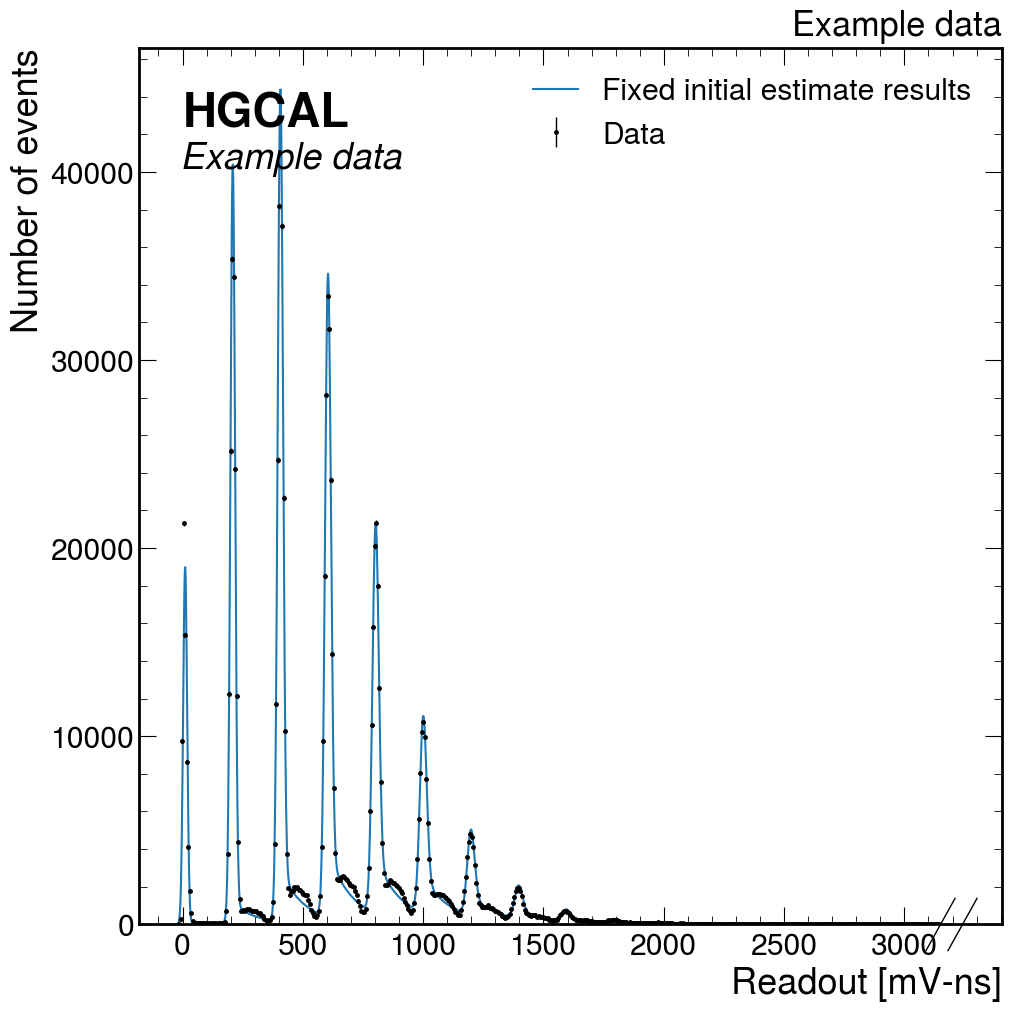

In [7]:
new_parameter_dict = sipmanalyze.fit.update_response_parameter_bounds(
    parameter_dict,
    result,
    relative_range=0.3,  # For fixed parameters set scale relative to central value
    fit_uncer_range=3.0,  # For fitted paramters set to fit uncertainty mutiple
)
new_parameter_dict["dc_res"] = 5e-3  # Fixing the resolution parameter again

pdf_unbinned, pdf_binned, zfit_data = sipmanalyze.fit.create_response_pdf_data(
    data_hist, new_parameter_dict, routine_name="float_all"
)


# Running the fitting routine
nll_bin = zfit.loss.BinnedNLL(pdf_binned, zfit_data)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll_bin)
result.hesse()
print(result)


# Plotting the results
fig, ax = plot.make_simple_figure()
plot.plot_data1d(
    ax=ax, data=data_hist, label="Data", histtype="errorbar", color="k", markersize=5
)
plot.plot_pdf1d(
    ax=ax, pdf=pdf_unbinned, data=zfit_data, label="Fixed initial estimate results"
)
plot.add_std_label(ax=ax, label="Example data", rlabel="Example data")
# ax.set_xlabel("Readout [mV-ns]")
ax.set_ylabel("Number of events")
ax.legend()